# Random Numbers

This notebook provides some more details on obtaining random numbers in Python and Pandas, and how to work with *random number generators* (RNGs).

We are just going to need a few packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import seedbank

C:\Users\michaelekstrand\scoop\apps\mambaforge\current\envs\cs533\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Generating Random Numbers

Computers to not generate *actually* random numbers.  Instead they generate *pseudorandom* numbers: numbers that, for our purposes, behave as if they were random, in that we canot predict (without knowing the generator's state) what the next number will be.

As we have seen, we often **seed** the random number generator so its results *are* predictable, so that we can reproduce results.

Let's create a random number generator with a particular seed:

In [2]:
rng = np.random.default_rng(42)

We can then get a number in the range $0 \le n \lt 50$:

In [3]:
rng.integers(50)

4

If we ask for a second number, we get a different one:

In [4]:
rng.integers(50)

38

If, however, we create *another* generator with the same seed, we get the same first number:

In [5]:
rng2 = np.random.default_rng(42)
rng2.integers(50)

4

The generator object stores a *state*, an internal number that is used to generate the next number, and updated each time we generate more numbers.  Without knowing what the state is, it is difficult to predict what the next number will be.  Such numbers, assuming they obey reasonable statistical properties, are a sufficiently close approximation to random that we can use them for simulations, bootstraps, and other things that need access to the ability to generate random numbers or make random decisions.  There are quite a few tests for determining if an RNG's output is “good enough”, which are outside the scope of this class.

## Modern Approach: NumPy Generators

The modern approach to doing random number generation in scientific Python code is to use a {py:class}`~numpy.random.Generator` object from NumPy.  The {py:func}`~numpy.random.default_rng` function creates such a generator, as we have seen above:

In [6]:
rng = np.random.default_rng(20221013)

NumPy actually supports multiple different random number generation algorithms, and `default_rng` creates one using the current default settings.  Future versions of NumPy may change those defaults, so sequences of numbers are only repeatable with the same NumPy version (and actually on the same OS & CPU architecture).

This object supports many different methods for producing different kinds of output. We have already seen {py:meth}`~numpy.random.Generator.integers`:

In [7]:
rng.integers(1000)

0

It can also generate multiple integers at once as an array:

In [8]:
rng.integers(1000, size=10)

array([222, 196, 114, 502, 953, 182, 213,  59, 367, 111], dtype=int64)

If we want random floating-point numbers in the range $[0,1]$, we can use {py:meth}`~numpy.random.Generator.random`:

In [9]:
rng.random()

0.8157251358428466

Like `integers`, and any other methods returning numbers, it can take a `size`:

In [10]:
rng.random(size=5)

array([0.68121396, 0.40387077, 0.87274614, 0.9671598 , 0.76114327])

The {py:class}`~numpy.random.Generator` class has methods to draw numbers from many distributions, like the normal:

In [11]:
rng.normal(0, 1)

-0.5737262994785399

We can see that these look pretty normal if we plot a histogram of many draws:

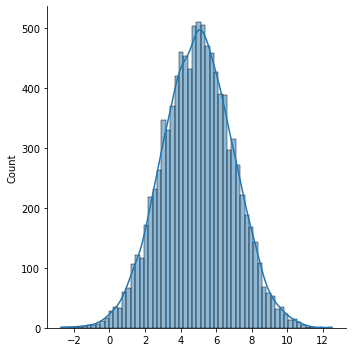

In [12]:
sns.displot(x=rng.normal(5, 2, size=10000), kde=True)
plt.show()

Another is the exponeitial:

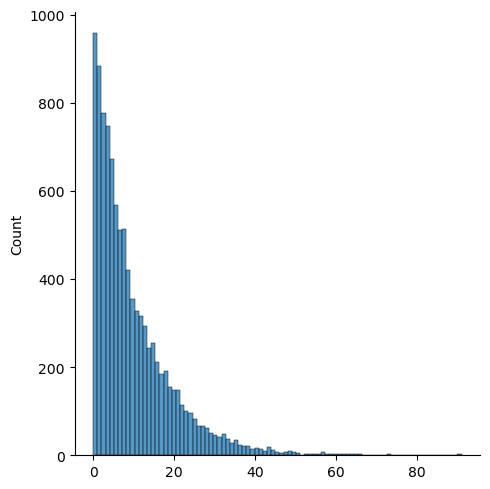

In [13]:
sns.displot(x=rng.exponential(10, size=10000))
plt.show()

The {py:meth}`~numpy.random.Generator.choice` method uses the random number generator to choose from a list or array of values. Let's make such an array:

In [14]:
vals = np.arange(0, 100, 5)
vals

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
       85, 90, 95])

And randomly pick 5 elements:

In [15]:
rng.choice(vals, 5)

array([70, 60, 30, 10, 40])

By default, the sampling is *with replacement* when we use `choice`. To make it without replacement:

In [16]:
rng.choice(vals, 5, replace=False)

array([85, 75, 25, 95, 20])

There are several other ways that `Generator` can generate random outputs. I recommend reading its documentation.

If you use SeedBank, you can create `Generator` objects using its {py:func}`seedbank.numpy_rng` function:

In [17]:
rng = seedbank.numpy_rng(95)
rng.integers(1000)

449

This function has some additional functionality, like reusing SeedBank's state from {py:func}`seedbank.initialize` if no generator seed is provided.

## Old Style: NumPy Functions

NumPy also exposes many functions directly from the {py:mod}`numpy.random` module that do not require you to have a random number generator object.  They work the same way as `Generator` methods, and some of them have the same names.

To generate some random floats according to the standard normal distribution:

In [18]:
np.random.randn(5)

array([ 0.91286021,  0.24710817,  0.23935922, -1.46121369, -0.75626629])

You can think about these functions as if they used a global `Generator` that's initialized when you start up Python.

:::{note}
The legacy random functions actually use a {py:class}`numpy.random.RandomState`, which is similar to a `Generator` but uses
an older design that is not getting updates in new NumPy versions.  You can usually just use generators, but you may sometimes interact with libraries that need a `RandomState` and cannot operate with a `Generator`.
:::

To initialize the seed of this shared, global RNG, you can use {py:func}`numpy.random.seed`:

In [19]:
np.random.seed(20201013)

In [20]:
np.random.randn(5)

array([ 0.29024655,  0.51061925,  0.10230704,  0.38427783, -0.42088693])

Alternatively, you can use {py:func}`seedbank.initialize`, which initializes both NumPy's global RNG and several others:

In [21]:
seedbank.initialize(20201013)

SeedSequence(
    entropy=20201013,
)

In [22]:
np.random.randn(5)

array([-0.88487992,  0.64911734, -0.91608294,  0.67446197, -0.85210414])

:::{note}
This produces different numbers because SeedBank uses a slightly different algorithm from `seed` to convert the seed you provide it into an actual RNG seed.  Both, however, will initialize the RNG to produce reproducible results.
:::

The {py:func}`numpy.random.choice` method works like {py:meth}`numpy.random.Generator.choice` as well.

## Random Sampling in Pandas

Pandas provides the {py:meth}`pandas.DataFrame.sample` method, and similar methods, to faciliate random sampling from data frames and series.  By default this samping is **without replacement** — its `replace` method has an opposite default as {py:meth}`~numpy.random.Generator.choice`.

By default, it also uses the NumPy global random number generator:

In [23]:
movies = pd.read_table('../data/hetrec2011-ml/movies.dat', sep='\t', encoding='latin1')
movies.sample(n=5)

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,...,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
4735,5049,48 Hrs.,83511,Límite 48 horas,http://ia.media-imdb.com/images/M/MV5BMTc2Mjc4...,1982,48_hrs,7.4,33,31,...,93,0,4,3,1,75,3.2,10471,61,http://content8.flixster.com/movie/26/94/26949...
8815,34482,The Browning Version,109340,La versión Browning,http://ia.media-imdb.com/images/M/MV5BMTY5MjM0...,1994,1055873-browning_version,6.7,16,13,...,81,0,3,1,2,33,3.5,322,63,http://content9.flixster.com/movie/28/01/28019...
7884,8918,Eulogy,349416,Eulogy,http://ia.media-imdb.com/images/M/MV5BMTIxMzIz...,2004,eulogy,4.6,34,11,...,32,3.9,9,1,8,11,3.6,2744,71,http://content6.flixster.com/movie/27/09/27091...
4721,5035,Wuthering Heights,32145,Cumbres borrascosas,http://ia.media-imdb.com/images/M/MV5BMTYyNDY3...,1939,1024192-wuthering_heights,7.9,16,16,...,100,0,1,1,0,100,3.9,2525,84,http://content7.flixster.com/movie/31/37/31379...
1647,1850,"I Love You, Don't Touch Me!",130019,"I Love You, Don't Touch Me!",http://ia.media-imdb.com/images/M/MV5BMTI5MTk0...,1997,i_love_you_dont_touch_me,5.4,10,4,...,40,0,1,1,0,100,3.1,352,44,http://content6.flixster.com/movie/10/85/09/10...


You can also pass a generator using the `random_state` option:

In [24]:
movies.sample(n=5, random_state=rng)

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,...,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
2306,2525,Albino Alligator,115495,Albino Alligator,http://ia.media-imdb.com/images/M/MV5BMTg1MjQ0...,1996,albino_alligator,5.5,17,8,...,47,5.4,6,2,4,33,3,1198,42,http://content8.flixster.com/movie/10/83/84/10...
5519,5857,So Fine,83099,Profesor a mi medida,http://ia.media-imdb.com/images/M/MV5BMjAxMTUy...,1981,so_fine,0,4,3,...,75,0,1,1,0,100,2.9,107,15,http://content6.flixster.com/movie/10/85/39/10...
4957,5278,Fraternity Vacation,89167,Fraternity Vacation,http://ia.media-imdb.com/images/M/MV5BMTc5Mjkz...,1985,fraternity_vacation,0,3,0,...,0,0,2,0,2,0,3,279,47,http://content9.flixster.com/movie/27/76/27769...
587,613,Jane Eyre,780362,Jane Eyre,http://ia.media-imdb.com/images/M/MV5BMTQ0Njkx...,2006,NaN,\N,\N,\N,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
9311,48982,Flushed Away,424095,Ratónpolis,http://ia.media-imdb.com/images/M/MV5BOTIwOTc5...,2006,flushed_away,6.7,128,92,...,71,6.7,33,25,8,75,3.3,58694,68,http://content6.flixster.com/movie/10/88/03/10...


## Recommendations

For quick-and-dirty code, I usually just call {py:func}`seedbank.initialize` at the top of my notebook, create a generator with the defaults for NumPy sampling, and then use Pandas' defaults for Pandas sampling.  The initialization code looks like this:

In [25]:
seedbank.initialize(20221013)
rng = seedbank.numpy_rng()

For more advanced code, particularly if I am writing library code to be used by others, I do everything by creating an {py:class}`~numpy.random.Generator` object and passing it around to other code that needs it.

:::{warning}
None of the random number generators here are **cryptographically secure**.  If you need random numbers that are unpredictable for security or cryptographic purposes, you will need to use a cryptographic random number generator, which is out-of-scope for the class.
:::